In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization
sns.set()
from pprint import pprint
import json
import fxcmpy
from sklearn import svm
from IPython import get_ipython
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')

In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
TOKEN ='8ea6466c9b90a9716bd26056a699639309f25fc4' #copy and paste access token from FXCM
con = fxcmpy.fxcmpy(access_token=TOKEN, log_level='error')
con.is_connected()

Connecting to FXCM Successful?


True

In [4]:
# print('Account ID')
# Account = con.get_account_ids()

In [5]:
# print('Open Orders')
# order_ids =con.get_order_ids()
# print(order_ids)

In [6]:
# print('Choose Instrument to trade')

In [7]:
# instruments = con.get_instruments()
# print(instruments)

In [8]:
# Ticker = str(input())

In [9]:
# Bars = str(input('Choose Bar Period' '\nMust be m1, m5, m15, m30, H1, H2, H3, H4, H6, H8, D1, W1 or M1: '))

In [ ]:
# Loop this update of candles every X minutes once the best optimisation has run
# Maybe save this this data to a table and append with each new update
# Maybe fork process to split Parent and Child process

In [10]:
try:
    df = con.get_candles('XAU/USD', period='m15', number=500)
except ValueError:
        print('Please Check Instrument or Period')

In [11]:
close = df.bidclose.values.tolist()
window_size = 30
skip = 5
l = len(close) - 1

In [12]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [13]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        max_buy,
        max_sell,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        profit = 0
        loss = 0
        for t in range(0, l, self.skip):
            action, buy = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                print(
                    'day %d: buy %d units at price %f, total balance %f'
                    % (t, buy_units, total_buy, initial_money)
                )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (t, sell_units, total_sell, invest, initial_money)
                )
                if invest > 0:
                    profit += 1
                else:
                    loss += 1
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        ratio = (profit / (loss + profit)) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (initial_money - starting_money, invest)
        )
        print(
            'total wins %d , total losses %d, accuracy ratio: %f'
            % (profit , loss , ratio)
            )
        print('left in inventory: %d' % (len(inventory)))
        print(inventory)
        print('\nPredicted Buy/Sell for ' +str(len(close))+ ' ROI: ' + str(int(invest))+'%')
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()

In [14]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        10000,
        5,
        5,
        skip,
        window_size,
    )
    try:
        agent.fit(10, 1000)
        return agent.es.reward_function(agent.es.weights)
    except:
        return 0

In [15]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size)),
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [16]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (2, 50),#standard: 2,50
        'skip': (1, 15), #standard: 1,15
        'population_size': (1, 50),#standard: 1,50
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.29),#standard: 0.000001 , 0.49
        'size_network': (1, 100),#standard: 10,1000
    },
)
NN_BAYESIAN.maximize(init_points = 50, n_iter = 80, acq = 'ei', xi = 0.0) #standard: init_points=30 n_iter=50

Initialization
----------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   learning_rate |   population_size |     sigma |   size_network |      skip |   window_size | 

Search parameters {'window_size': 22, 'skip': 10, 'population_size': 2, 'sigma': 0.6425338728564258, 'learning_rate': 0.1386927802703741, 'size_network': 9}
time taken to train: 0.029769420623779297 seconds
stop after 100 iteration with investment 0.028500
    1 | 00m00s |    0.02850 |          0.1387 |            2.0542 |    0.6425 |         9.0142 |    9.5341 |       22.1328 | 

Search parameters {'window_size': 37, 'skip': 11, 'population_size': 6, 'sigma': 0.8057802471879668, 'learning_rate': 0.06926916816985192, 'size_network': 17}
time taken to train: 0.0801389217376709 seconds
stop after 100 iteration with investment -12.635600
    2 | 00m00s |  -12.63560 |          0.0693 |            6.1408 |    0.8058 |        17.

time taken to train: 1.389937162399292 seconds
stop after 100 iteration with investment 0.519600
   21 | 00m01s |    0.51960 |          0.1596 |           37.1123 |    0.2291 |        60.9126 |    3.5472 |       40.9689 | 

Search parameters {'window_size': 39, 'skip': 14, 'population_size': 17, 'sigma': 0.0277589647702996, 'learning_rate': 0.06293828188989273, 'size_network': 30}


C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


stop after 100 iteration with investment 0.000000
   22 | 00m00s |    0.00000 |          0.0629 |           17.2639 |    0.0278 |        30.2953 |   14.2383 |       38.5838 | 

Search parameters {'window_size': 50, 'skip': 6, 'population_size': 48, 'sigma': 0.2577118969141056, 'learning_rate': 0.15297934476996414, 'size_network': 71}
time taken to train: 1.4299817085266113 seconds
stop after 100 iteration with investment 0.978900
   23 | 00m01s |    0.97890 |          0.1530 |           48.3077 |    0.2577 |        70.9732 |    5.6963 |       49.9647 | 

Search parameters {'window_size': 20, 'skip': 5, 'population_size': 15, 'sigma': 0.63889230562753, 'learning_rate': 0.08800562351348493, 'size_network': 22}
time taken to train: 0.31994152069091797 seconds
stop after 100 iteration with investment -0.182700
   24 | 00m00s |   -0.18270 |          0.0880 |           14.7223 |    0.6389 |        21.7589 |    5.2626 |       19.8126 | 

Search parameters {'window_size': 39, 'skip': 12, 'popu

time taken to train: 0.330094575881958 seconds
stop after 100 iteration with investment -12.743500
   44 | 00m00s |  -12.74350 |          0.0582 |           41.2856 |    0.0991 |        20.0991 |   10.0523 |        3.7806 | 

Search parameters {'window_size': 16, 'skip': 9, 'population_size': 45, 'sigma': 0.910984376008568, 'learning_rate': 0.17391517277074897, 'size_network': 8}
time taken to train: 0.5297503471374512 seconds
stop after 100 iteration with investment 0.229900
   45 | 00m00s |    0.22990 |          0.1739 |           44.9820 |    0.9110 |         8.1789 |    8.8590 |       15.9325 | 

Search parameters {'window_size': 7, 'skip': 7, 'population_size': 1, 'sigma': 0.14711383915535112, 'learning_rate': 0.12631092998880095, 'size_network': 97}
stop after 100 iteration with investment 0.000000
   46 | 00m00s |    0.00000 |          0.1263 |            1.0239 |    0.1471 |        97.2021 |    6.7250 |        7.4498 | 

Search parameters {'window_size': 20, 'skip': 4, 'populat

C:\Users\Bl4ckP3n9u1n\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide



Search parameters {'window_size': 3, 'skip': 2, 'population_size': 3, 'sigma': 0.9645005630756355, 'learning_rate': 0.16934096243221747, 'size_network': 11}
time taken to train: 0.1245887279510498 seconds
stop after 100 iteration with investment 0.056500
   52 | 00m01s |    0.05650 |          0.1693 |            3.2459 |    0.9645 |        10.8881 |    1.5973 |        2.6360 | 

Search parameters {'window_size': 2, 'skip': 3, 'population_size': 3, 'sigma': 0.01, 'learning_rate': 1e-06, 'size_network': 8}
time taken to train: 0.07056713104248047 seconds
stop after 100 iteration with investment 0.058600
   53 | 00m19s |    0.05860 |          0.0000 |            3.0363 |    0.0100 |         7.7695 |    3.3153 |        2.0000 | 

Search parameters {'window_size': 2, 'skip': 2, 'population_size': 3, 'sigma': 0.2424455224366295, 'learning_rate': 1e-06, 'size_network': 10}
time taken to train: 0.10974907875061035 seconds
stop after 100 iteration with investment -0.075600
   54 | 00m18s |   -

stop after 100 iteration with investment 0.070100
   73 | 00m02s |    0.07010 |          0.1343 |           15.3367 |    0.7316 |        94.2341 |   14.2616 |       39.1482 | 

Search parameters {'window_size': 38, 'skip': 15, 'population_size': 34, 'sigma': 0.2416746650385886, 'learning_rate': 0.05902830624509248, 'size_network': 96}
time taken to train: 0.3803696632385254 seconds
stop after 100 iteration with investment -25.925300
   74 | 00m02s |  -25.92530 |          0.0590 |           34.4542 |    0.2417 |        95.5531 |   14.9939 |       37.8634 | 

Search parameters {'window_size': 11, 'skip': 3, 'population_size': 39, 'sigma': 0.6364920169468391, 'learning_rate': 0.2787225107245644, 'size_network': 63}
time taken to train: 1.2352709770202637 seconds
stop after 100 iteration with investment 0.068800
   75 | 00m03s |    0.06880 |          0.2787 |           38.5642 |    0.6365 |        62.8733 |    2.6708 |       11.3802 | 

Search parameters {'window_size': 8, 'skip': 13, 'pop


Search parameters {'window_size': 39, 'skip': 4, 'population_size': 4, 'sigma': 0.7868684500089025, 'learning_rate': 0.19226206142433258, 'size_network': 24}
time taken to train: 0.14017629623413086 seconds
stop after 100 iteration with investment -12.156400
   95 | 00m02s |  -12.15640 |          0.1923 |            4.0129 |    0.7869 |        23.6026 |    3.5164 |       38.9657 | 

Search parameters {'window_size': 7, 'skip': 8, 'population_size': 43, 'sigma': 0.5164954570233573, 'learning_rate': 0.2876488694754773, 'size_network': 54}
time taken to train: 0.4750204086303711 seconds
stop after 100 iteration with investment 0.167100
   96 | 00m02s |    0.16710 |          0.2876 |           42.8504 |    0.5165 |        53.9968 |    7.5320 |        7.3205 | 

Search parameters {'window_size': 39, 'skip': 4, 'population_size': 41, 'sigma': 0.2375172949231506, 'learning_rate': 0.04327508000229972, 'size_network': 32}
time taken to train: 1.4399309158325195 seconds
stop after 100 iteration

time taken to train: 2.4702863693237305 seconds
stop after 100 iteration with investment -12.668900
  116 | 00m05s |  -12.66890 |          0.0805 |           19.8973 |    0.4888 |        31.4864 |    1.0867 |       30.0221 | 

Search parameters {'window_size': 47, 'skip': 12, 'population_size': 35, 'sigma': 0.6099882172386416, 'learning_rate': 0.1897078336015918, 'size_network': 50}
time taken to train: 0.6049213409423828 seconds
stop after 100 iteration with investment 0.282500
  117 | 00m03s |    0.28250 |          0.1897 |           35.3515 |    0.6100 |        50.1499 |   12.2899 |       46.5482 | 

Search parameters {'window_size': 18, 'skip': 4, 'population_size': 27, 'sigma': 0.23853105377504075, 'learning_rate': 0.11177463375189878, 'size_network': 67}
time taken to train: 0.7601158618927002 seconds
stop after 100 iteration with investment 0.305500
  118 | 00m03s |    0.30550 |          0.1118 |           27.2909 |    0.2385 |        67.2461 |    4.3932 |       18.3557 | 

Sear

In [17]:
print('Best AGENT accuracy value: %f' % NN_BAYESIAN.res['max']['max_val'])
print('Best AGENT parameters: ', NN_BAYESIAN.res['max']['max_params'])

Best AGENT accuracy value: 1.979000
Best AGENT parameters:  {'window_size': 2.364225107567954, 'skip': 2.1445645169898366, 'population_size': 3.1879386584717606, 'sigma': 0.6181143601855591, 'learning_rate': 0.03393825676737686, 'size_network': 9.906163419706001}


In [18]:
bayes_res = str(NN_BAYESIAN.res['max']['max_params'])
bayes_res = json.loads(bayes_res.replace("'", "\""))
bayes_res['window_size'] = int(round(bayes_res['window_size']))
bayes_res['skip'] = int(round(bayes_res['skip']))
bayes_res['population_size'] = int(round(bayes_res['population_size']))
bayes_res['size_network'] = int(round(bayes_res['size_network']))
pprint(bayes_res)

{'learning_rate': 0.03393825676737686,
 'population_size': 3,
 'sigma': 0.6181143601855591,
 'size_network': 10,
 'skip': 2,
 'window_size': 2}


In [19]:
# print(NN_BAYESIAN.max)


# params = NN_BAYESIAN.max['params']

time taken to train: 0.10365438461303711 seconds
day 8: buy 1 units at price 1281.430000, total balance 318.570000
day 12, sell 1 units at price 1284.040000, investment 0.203679 %, total balance 1602.610000,
day 22: buy 1 units at price 1285.220000, total balance 317.390000
day 24, sell 1 units at price 1286.090000, investment 0.067693 %, total balance 1603.480000,
day 52: buy 1 units at price 1283.800000, total balance 319.680000
day 58, sell 1 units at price 1283.660000, investment -0.010905 %, total balance 1603.340000,
day 64: buy 1 units at price 1283.480000, total balance 319.860000
day 68, sell 1 units at price 1283.710000, investment 0.017920 %, total balance 1603.570000,
day 80: buy 1 units at price 1282.320000, total balance 321.250000
day 92, sell 1 units at price 1281.580000, investment -0.057708 %, total balance 1602.830000,
day 104: buy 1 units at price 1282.210000, total balance 320.620000
day 106, sell 1 units at price 1283.100000, investment 0.069411 %, total balance 1

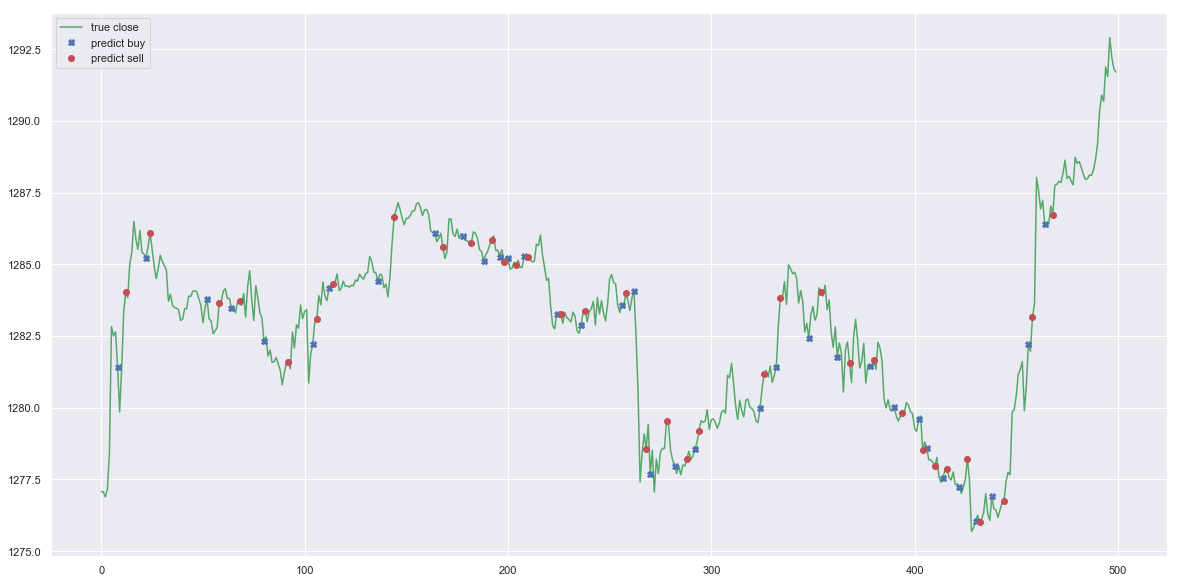

In [20]:
# 1600 = Funds or Margin, Buy / Sell = 200 , 200
model = Model(bayes_res['window_size'], bayes_res['size_network'], 3)
agent = Agent(
    bayes_res['population_size'], bayes_res['sigma'], bayes_res['learning_rate'], model, 1600, 200, 200, bayes_res['skip'], bayes_res['window_size']
)
agent.fit(bayes_res['size_network'], 100)
agent.buy()